In [10]:
from src.helpers import setup_env, compute_mean_and_std, plot_confusion_matrix
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize, one_epoch_test
from src.transfer import get_model_transfer_learning
from src.predictor import Predictor, predictor_test
import torch

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    torch.cuda.empty_cache()
    print(f'Memory allocated: {torch.cuda.memory_allocated()}')
    print(f'Max memory allocated: {torch.cuda.max_memory_allocated()}')

# If running locally, this will download dataset
setup_env()

CUDA is available!  Training on GPU ...
Memory allocated: 0
Max memory allocated: 0
GPU available
Dataset already downloaded. If you need to re-download, please delete the directory data\landmark_images
Reusing cached mean and std


Let's train our transfer learning model! Let's start defining the hyperparameters:

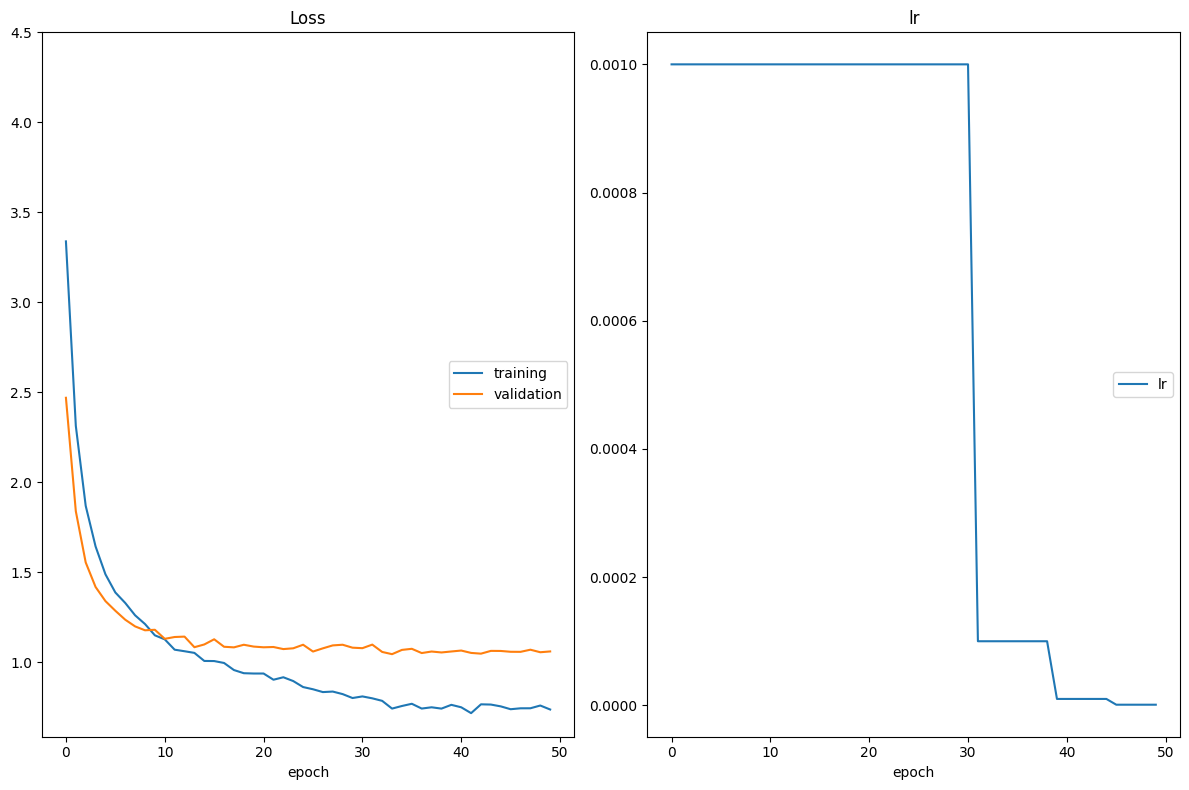

In [6]:
batch_size = 64  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
numEpochs = 50  # number of epochs for training
numClasses = 50  # number of classes. Do not change this
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0 # regularization. Increase this to combat overfitting

# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the values
netTransfer = get_model_transfer_learning(model_name="resnet18", n_classes=numClasses)

# train the model
dataLoaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    netTransfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)

loss = get_loss()

optimize(
    dataLoaders,
    netTransfer,
    optimizer,
    loss,
    n_epochs=numEpochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True,
    train_on_gpu=train_on_gpu
)

Test the model on the test dataset of landmark images. The code cell below calculates and prints the test loss and accuracy.

In [7]:
# Load saved weights
netTransfer.load_state_dict(torch.load('checkpoints/model_transfer.pt'))

one_epoch_test(dataLoaders['test'], netTransfer, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:19<00:00,  1.04it/s]

Test Loss: 0.949082


Test Accuracy: 74% (933/1250)


0.9490821987390516

Just like what we did with our original model, we export the best fit model using torchscript so that it can be used in our application. We again use the Predictor class to export the model after testing it on our test data set.

In [8]:
# Get the class names from our data loaders
class_names = dataLoaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU (we don't need GPU for inference)
netTransfer = netTransfer.cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
netTransfer.load_state_dict(torch.load("checkpoints/model_transfer.pt", map_location="cpu"))

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(netTransfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


100%|███████████████████████████████████████| 1250/1250 [00:39<00:00, 31.70it/s]


Accuracy: 0.748


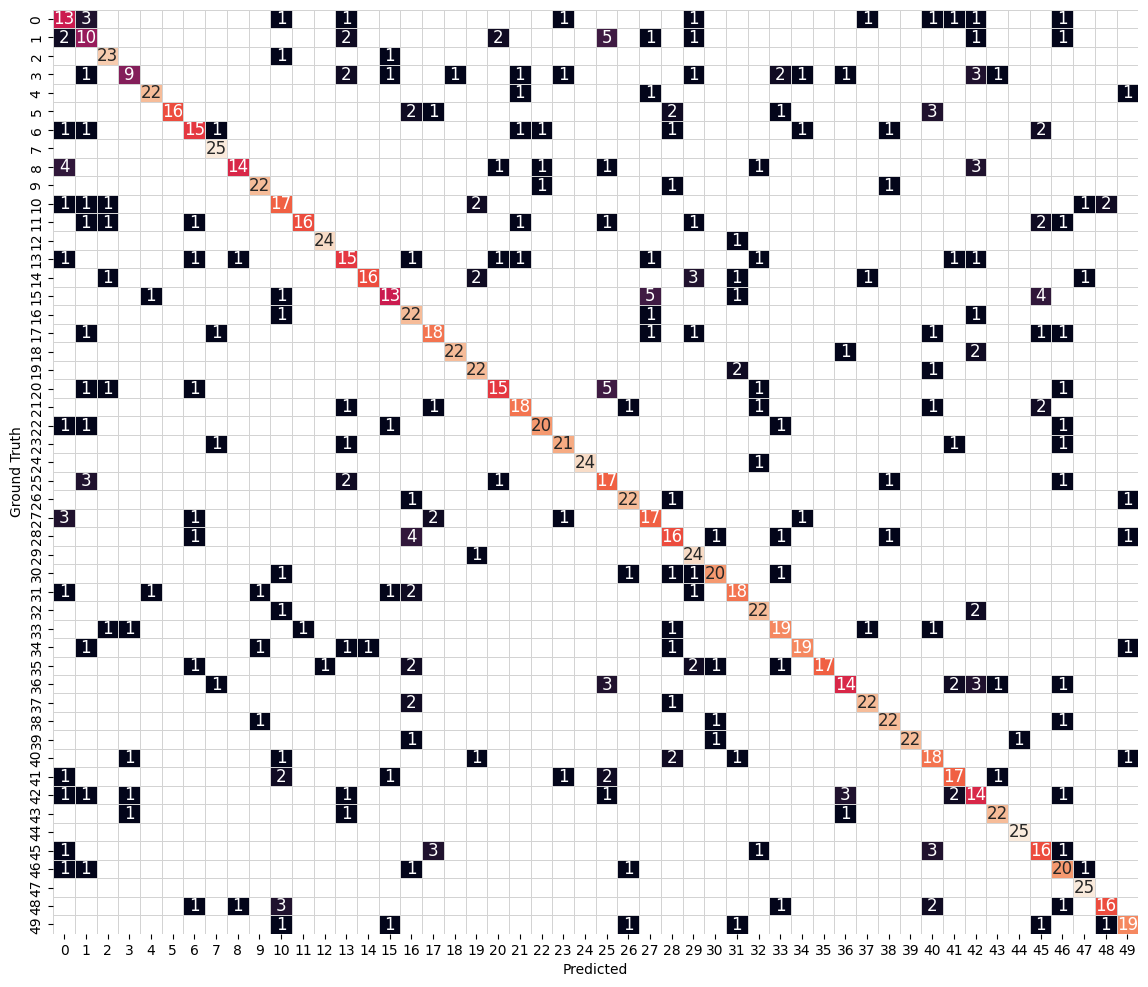

In [11]:
netReloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(dataLoaders['test'], netReloaded)

plot_confusion_matrix(pred, truth)